In [1]:
# Inline Plotting
%matplotlib inline

# Multi-Agent Reinforcement Learning Experiment

Note: This is an implement of the MADDPG algorithm based on the essay "Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments".

## 0. Preparation

At the very beginning, let's import needed packages. We choose pettingzoo as our environment, installed by using `pip`.

In [ ]:
# Install packages
%pip install pettingzoo[mpe]
%pip install openpyxl

We'll also use the following from PyTorch:

- neural networks (torch.nn)
- optimization (torch.optim)

Matplotlib and Openpyxl are used for saving and visualizing our results.

In [2]:
# Import libraries
import random
from collections import namedtuple, deque

import matplotlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from pettingzoo.mpe import simple_adversary_v3
from psutil import virtual_memory

 Now,let's check the system memory and  NVIDIA Information.

In [3]:
# Run in the Colab
run_in_colab = False
if run_in_colab:
    # Check NVIDIA information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    # Check memory information
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
        print('Not using a high-RAM runtime')
    else:
        print('You are using a high-RAM runtime!')

Thu Aug 17 17:15:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P0              11W / 120W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## 1. Replay Buffer

Replay Buffer is a method of data storage and retrieval used in Reinforcement Learning. Its principle is to store the agent's experience in the environment in a buffer, and then to randomly extract some of the data from the buffer during training for learning. This has two advantages: first, it improves the utilisation rate of the data and avoids the waste of discarding it only once each time; second, it breaks the temporal correlation of the data and reduces the instability of the training. We chose to implement it with a circular queue of fixed size, and when the queue is full, the oldest data is automatically discarded.

For this, we're going to need two classes:

- `Transition` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
- `ReplayBuffer` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a `.sample()` method for selecting a random batch of transitions for training.

In [5]:
"""Transition is a namedtuple used to store a transition.

The structure of Transition looks like this:
    (state, action, reward, next_state, done)
"""
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayBuffer:
    """ReplayBuffer is a class used to achieve experience replay.

    It's a buffer composed of a deque with a certain capacity. When the deque is full, it will automatically remove the oldest transition in the buffer.

    Attributes:
        _storage: The buffer to store the transitions.

    Examples:
        A replay buffer structure looks like below:
        [
            (state_1, action_1, reward_1, next_state_1, done_1),
            (state_2, action_2, reward_2, next_state_2, done_2),
            ...
            (state_n, action_n, reward_n, next_state_n, done_n),
        ]
        Each tuple is a transition.
    """

    def __init__(self, capacity=100_000):
        """Initial a replay buffer with capacity.

        Args:
            capacity: Max length of the buffer.
        """
        self._storage = deque([], maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        Args:
            state:          The state of the agents.
            action:         The action of the agents.
            reward:         The reward of the agents.
            next_state:     The next state of the agents.
            done:           The termination of the agents.

        Returns: None

        """
        transition = Transition(state, action, reward, next_state, done)
        self._storage.append(transition)

    def sample(self, batch_size):
        """Sample a batch of transitions from the buffer.

        Args:
            batch_size: The number of transitions that we want to sample from the buffer.

        Returns: A batch of transitions.

        Example:
            Assuming that batch_size=3, we'll randomly sample 3 transitions from the buffer:
                state_batch = (state_1, state_2, state_3)
                action_batch = (action_1, action_2, action_3)
                reward_batch = (reward_1, reward_2, reward_3)
                next_state_batch = (next_state_1, next_state_2, next_state_3)
                done_batch = (done_1, done_2, done_3)
        """
        transitions = random.sample(self._storage, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*transitions)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        """Return the length of the buffer."""
        return len(self._storage)

## 2. Simple Neural Network

This code is a simple neural network class written in the PyTorch framework. It has the following characteristics:

- It inherits the `nn.Module` class, which is the base class for all neural network models in PyTorch.
- It defines three fully connected layers (`nn.Linear`), which are the input layer, the hidden layer and the output layer. Its parameters are input dimensions, output dimensions and hidden dimensions.
- It defines the `forward` propagation process of the neural network in the forward method. It first passes the input data $x$ through the first layer and applies the ReLU activation function (`F.relu`) to it. It then passes the result through the second layer again and applies the `relu` activation function again. Finally, it passes the result through the third layer and returns the output data.

The reasons we use three-layer neural networks are as follows:
- Each linear layer introduces additional parameters and nonlinear activation functions, which increase the complexity and flexibility of the model. More linear layers mean that models can learn richer feature representations and better fit complex relationships between inputs and outputs
- If the model is too complex and the amount of training data is relatively small, it is prone to overfitting problems. Too many linear layers increase the complexity of the model and make it easier to remember the details of the training sample, ignoring the ability to generalize to new data.
- DQN is based on Q-learning algorithm ，which usually adopts three-layer CNN structure.

In [6]:
class SimpleNet(nn.Module):
    """SimpleNet is a 3-layer simple neural network.

    It's used to approximate the policy functions and the value functions.
    """

    def __init__(self, input_dim, output_dim, hidden_dim):
        """Initial a simple network for an actor or a critic.

        Args:
            input_dim: The input dimension of the network.
            output_dim: The output dimension of the network.
            hidden_dim: The hidden layer dimension of the network.
        """
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## 3. Gumbel Softmax Trick

The action space of each agent in an MPE environment is discrete. The DDPG algorithm we use must itself make the agent's actions derivable for its strategy parameters, which is true for continuous action space, but not for discrete action space. However, this does not mean that the current task cannot be solved using the MADDPG algorithm, because we can use a method called Gumbel-Softmax to get an approximate sample of the discrete distribution. Below we briefly introduce its principles and provide the implementation code.

Suppose you have a random variable that follows a discrete distribution $K=(a_1,...,a_k)$. Then $a_i\in[0,1]$ means $P(Z=i)$ and $\sum_{i = 1}^{k}a_i=1$. If we want to sample according to this distribution $z\sim K$, we can see that sampling this discrete distribution is not derivable.

So is there a way to make discrete sampling controllable? The answer is heavy parameterisation, and we use the Gumbel-Softmax technique. Specifically, we introduce a heavy parameter factor $g_i$, which is a noise sampled from $Gumbel(0，1)$: $$g_i=-log(-logu),u\sim Uniform(0,1)$$Gumbel Softmax samples can be written as:$$y_i=\frac{exp((loga_i+g_i)/\tau)}{\sum_{j = 1}^{k}exp((loga_j+g_i)/\tau)},i=1,...,k.$$

In this case, if the discrete value is calculated by $z=\arg max_iy_i$, the discrete value is approximately equivalent to the value sampled by the discrete $z\sim K$. Furthermore, the gradient for $a$ is naturally introduced into the sample result $y$. $\tau>0$ is called the temperature parameter of the distribution, and by adjusting it one can control how similar the generated Gumbel-Softmax distribution is to the discrete distribution: the smaller $\tau$, the more the resulting distribution tends to be the result $onehot(\arg max_iloga_i+g_i)$; the larger $\tau$, the more the resulting distribution tends to be uniformly distributed.

Next, define some of the utility functions that need to be used, including functions related to Gumbel Softmax sampling, which allows DDPG to be applied to discrete action spaces.

In [7]:
def trans2onehot(logits, eps=0.01):
    """Transform the output of the actor network to a one-hot vector.

    Args:
        logits:     The output value of the actor network.
        eps:        The epsilon parameter in the epsilon-greedy algorithm used to choose an action.

    Returns: An action in one-hot vector form.

    """
    # Generates a one-hot vector form of the action selected by the actor network.
    best_action = (logits == logits.max(1, keepdim=True)[0]).float()
    # Generate a one-hot vector form of a random action.
    size, num_actions = logits.shape
    random_index = np.random.choice(range(num_actions), size=size)
    random_actions = torch.eye(num_actions)[[random_index]].to(logits.device)
    # Select an action using the epsilon-greedy algorithm.
    random_mask = torch.rand(size, device=logits.device) <= eps
    selected_action = torch.where(random_mask.view(-1, 1), random_actions, best_action)
    return selected_action


def sample_gumbel(shape, eps=1e-20, tensor_type=torch.float32):
    """Sample a Gumbel noise from the Gumbel(0,1) distribution."""
    U = torch.rand(shape, dtype=tensor_type, requires_grad=False)
    gumbel_noise = -torch.log(-torch.log(U + eps) + eps)
    return gumbel_noise


def gumbel_softmax_sample(logits, temperature):
    """Sample from the Gumbel-Softmax distribution."""
    gumbel_noise = sample_gumbel(logits.shape, tensor_type=logits.dtype).to(logits.device)
    y = logits + gumbel_noise
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """Sample from Gumbel-Softmax distribution and discretize it.

    By returning a one-hot vector of y_hard, but with a gradient of y, we can get both a discrete action interacting with the environment and a correct inverse gradient.
    """
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = trans2onehot(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    return y

## 4. DDPG

Next we will use the deep deterministic policy gradient (DDPG) algorithm, which constructs a deterministic policy that uses gradient ascent to maximize values. DDPG is also an actor-critic algorithm. 

If the policy is deterministic, it can be denoted by $a=u_\theta(s)$. Similar to the policy gradient theorem, we can derive the deterministic policy gradient theorem:$$\nabla_{\theta} J\left(\pi_{\theta}\right)=\mathbb{E}_{s \sim \nu^{\pi_{\beta}}}\left[\left.\nabla_{\theta} \mu_{\theta}(s) \nabla_{a} Q_{\omega}^{\mu}(s, a)\right|_{a=\mu_{\theta}(s)}\right]$$

where $\pi _\beta$ is the policy used to collect data. We can understand this theorem as follows: suppose there is already a function $Q$ given a state $s$. But since the action space is now infinite, it is not possible to find the action with the largest value of $Q$ by iterating over all actions, so we want to use the policy $u$ to find the action $a$ that maximises the value of $Q(s,a)$: $u(s)=\arg max_aQ(s,a)$.

To get $u$, we first use $Q$ to derive a derivative $\nabla _\theta Q(s,u_\theta (s))$ of $u_\theta$, which uses the chain rule of the gradient, first for $a$ and then for $\theta$. The function $Q$ is then maximised by a gradient ascent to get the action with the largest $Q$ value.

DDPG uses four neural networks, one each for Actor and Critic, and one each for a target network. In DDPG, Actors also need a target net, as the target net is also used to calculate the target value $Q$. The update of the target &Q& network in DDPG is slightly different from that in DQN: in DQN, the $Q$ network is replicated directly to the target $Q$ network at regular intervals; in DDPG, the update of the target $Q$ network uses a soft update method, i.e. the target $Q$ network is updated slowly and gradually approaches the $Q$ network, and its formula is$$w^-\leftarrow \tau w+(1-\tau)w^-$$

Usually $\tau$ is a relatively small number, and when $\tau=1$ it is consistent with how the DQN is updated. The target network $u$ also uses this soft update method.

In addition, due to the problem of overestimating the $Q$ value of the function $Q$, DDPG uses the technology in Double DQN to update the network. However, because DDPG uses a deterministic strategy, its own exploration is still very limited. Remembering the DQN algorithm, its exploration is mainly generated by the behaviour of the greedy strategy. Also as an algorithm for offline strategies, DDPG introduces a random noise on the behavioural strategies to explore.

Both the strategy network and the value network use a single hidden layer neural network. The output layer of the strategy network uses the tangent function $y=\tanh x$ as the activation function, because the value domain of the tangent function is $[-1,1]$, which is convenient to scale to the range of actions acceptable to the environment. In DDPG, which deals with environments that interact with continuous actions, the input to the x-network is a vector of states and actions concatenated together, and the output of the x-network is a value representing the value of that state-action pair.

When taking actions with a policy network, we add Gaussian noise to the actions for better exploration. In the original DDPG paper, the added noise corresponds to the Ornstein-Uhlenbeck (OU) stochastic process:$$\Delta x_{t}=\theta\left(\mu-x_{t-1}\right)+\sigma W$$

where $u$ is the mean, $W$ is random noise following Brownian motion, and $\theta$ and $\sigma$ are scale parameters. It can be seen that $x(t-1)$ when deviating from the mean, the value of $x_t$ moves closer to the mean. the OU stochastic process is characterised by a linear negative feedback around the mean with an additional disturbance term.

In [8]:
class DDPG:
    """The DDPG Algorithm.

    1. Each instance of DDPG corresponds an agent.
    2. Each instance of DDPG consists of an actor (policy network) and a critic (value network).
    3. Each instance of DDPG contains a set of target networks for its actor and critic (affected by the double DQN strategy).
    4. Network update function is contained in the Center Controller class, the MADDPG class, so that we can achieve the Centralized Training and Decentralized Execution method easily.

    Attributes:
        actor:              The Actor (Policy Network).
        target_actor:       The Target Actor (Target Policy Network).
        critic:             The Critic (value Network).
        target_critic:      The Target Critic (Target Value Network).
        actor_optimizer:    The optimizer of Actor.
        critic_optimizer:   The optimizer of Critic.
    """

    def __init__(self, state_dim, action_dim, critic_dim, hidden_dim, actor_lr, critic_lr, device):
        """Initialize a DDPG instance for an agent.

        Args:
            state_dim:      The dimension of the state, which is also the input dimension of Actor and a part of Critics' input.
            action_dim:     The dimension of the action, which is also a part of Critics' input.
            critic_dim:     The dimension of the Critics' input (Critic Dimension = State Dimensions + Action Dimension).
            hidden_dim:     The dimension of the hidden layer of the networks.
            actor_lr:       The learning rate for the Actor.
            critic_lr:      The learning rate for the Critic.
            device:         The device to compute.
        """
        # Set Actor with Target Network
        self.actor = SimpleNet(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = SimpleNet(state_dim, action_dim, hidden_dim).to(device)
        # Set Critic with Target Network
        self.critic = SimpleNet(critic_dim, 1, hidden_dim).to(device)
        self.target_critic = SimpleNet(critic_dim, 1, hidden_dim).to(device)
        # Load parameters from Actor and Critic to their target networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        # Set up optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def take_action(self, state, explore=False):
        """Take action from the Actor (Policy Network).

        1. State -> the Actor -> Action Value
        2. Choose action according to the value of explore.
            - explore == True: Choose an action based on the gumbel trick.
            - explore == False: Choose the action from the Actor, and transform the value to a one-hot vector.

        Args:
            state:      The partial observation of the agent.
            explore:    The strategy to choose action.

        Returns: The action that the Actor has chosen.

        """
        # Choose an action from actor network (deterministic policy network).
        action = self.actor(state)
        # Exploration and Exploitation
        if explore:
            action = gumbel_softmax(action)
        else:
            action = trans2onehot(action)
        # TODO: Find out why the action need to be transferred to the CPU
        # return action.detach().cpu().numpy()[0]
        return action.detach().cpu().numpy()[0]

    @staticmethod
    def soft_update(net, target_net, tau):
        """Soft update function, which is used to update the parameters in the target network.

        Args:
            net:            The original network.
            target_net:     The target network.
            tau:            Soft update parameter.

        Returns: None

        """
        # Update target network's parameters using soft update strategy
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

## 5. MADDPG

The multi-agent DDPG algorithm literally means an algorithm that implements a DDPG for each agent. All agents share a centralised critic network that simultaneously guides each agent's actor network during the training process, and each agent's actor network acts completely independently, i.e. decentralised execution.
The main detail of the MADDPG algorithm is that each agent is trained with the Actor-Critic method, but unlike the traditional single agent, the Critic part of each agent in MADDPG can obtain the strategy information of other agents. Specifically, if we consider a game with $N$ agents, each agent's policy parameter is $\theta=\lbrace \theta_1,...,\theta _N \rbrace$, and $\pi=\lbrace \pi_1,...,\pi _N \rbrace$ is the set of strategies for all agents, then we can write the policy gradient of each agent's expected return in the case of a random strategy:$$\nabla_{\theta_{i}} J\left(\theta_{i}\right)=\mathbb{E}_{s \sim p^{\mu}, a \sim \pi_{i}}\left[\nabla_{\theta_{i}} \log \pi_{i}\left(a_{i} \mid o_{i}\right) Q_{i}^{\pi}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)\right]$$

$Q_i^\pi=(\mathbf{x},a_1,...,a_N)$ is a centralised action value function. Why is $Q_i$ a centralised action value function? In general, $\mathbf{x}=(o_1,...,o_N)$ contains the observations of all agents, and $Q_i$ must also contain the actions of all agents at that moment, so the premise of $Q_i$ is that all agents must give their own observations and corresponding actions at the same time.

For a deterministic strategy, considering that there are now $N$ successive strategies $\mu_{\theta_{i}}$, we can get the gradient formula for DDPG:$$\nabla_{\theta_{i}} J\left(\theta_{i}\right)=\mathbb{E}_{s \sim p^{\mu}, a \sim \pi_{i}}\left[\nabla_{\theta_{i}} \log \pi_{i}\left(a_{i} \mid o_{i}\right) Q_{i}^{\pi}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)\right]\nabla_{\theta_{i}} J\left(\mu_{i}\right)=\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left.\nabla_{\theta_{i}} \mu_{i}\left(o_{i}\right) \nabla_{a_{i}} Q_{i}^{\mu}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)\right|_{a_{i}=\mu_{i}\left(o_{i}\right)}\right]$$

$D$ is the empirical playback pool we use to store data, and every piece of data it stores is $(\mathbf{x},\mathbf{x}',a_1,...,a_N,r_1,...,r_N)$. In MADDPG, the centralized action value function can be updated with the following loss function:$$\mathcal{L}\left(\omega_{i}\right)=\mathbb{E}_{\mathbf{x}, a, r, \mathbf{x}^{\prime}}\left[\left(Q_{i}^{\mu}\left(\mathbf{x}, a_{1}, \ldots, a_{N}\right)-y\right)^{2}\right], \quad y=r_{i}+\left.\gamma Q_{i}^{\mu^{\prime}}\left(\mathbf{x}^{\prime}, a_{1}^{\prime}, \ldots, a_{N}^{\prime}\right)\right|_{a_{j}^{\prime}=\mu_{j}^{\prime}\left(o_{j}\right)}$$

$\mu^{\prime}=\left(\mu_{\theta_{1}}^{\prime}, \ldots, \mu_{\theta_{N}}^{\prime}\right)$ is the set of target policies used in the update value function, which have parameters for deferred updates.


In [9]:
class MADDPG:
    """The Multi-Agent DDPG Algorithm.

    1. The instance of MADDPG is the Center Controller in the algorithm.
    2. The instance of MADDPG contains a list of DDPG instances, which are corresponded with the agents in the environment one by one.

    Attributes:
        agents:     A list of DDPG instances, which are corresponded with the agents in the environment one by one.
        device:     The device to compute.
        gamma:      The gamma parameter in TD target.
        tau:        The tau parameter for soft update.
        critic_criterion: The loss function for the Critic networks.
    """

    def __init__(self, state_dims, action_dims, critic_dim, hidden_dim, actor_lr, critic_lr, device, gamma, tau):
        """Initialize a MADDPG instance as the Center Controller.

        Args:
            state_dims: A list of dimensions of each agent's observation.
            action_dims: A list of dimensions of each agent's action.
            critic_dim: The dimension of the Critic networks' input.
            hidden_dim: The dimension of the networks' hidden layers.
            actor_lr: The learning rate for the Actor.
            critic_lr: The learning rate for the Critic.
            device: The device to compute.
            gamma: The gamma parameter in TD target.
            tau: The tau parameter for soft update.
        """
        # TODO: Should we use dict to combine the DDPG instance with agents?
        self.agents = [
            DDPG(state_dim, action_dim, critic_dim, hidden_dim, actor_lr, critic_lr, device)
            for state_dim, action_dim in zip(state_dims, action_dims)
        ]
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = nn.MSELoss()

    @property
    def policies(self):
        """A list of Actors for the agents."""
        return [agent.actor for agent in self.agents]

    @property
    def target_policies(self):
        """A list of Target Actors for the agents."""
        return [agent.target_actor for agent in self.agents]

    def take_action(self, states, explore):
        """Take actions from the Actors (Policy Networks).

        Args:
            states: A list of observations from all the agents.
            explore: The strategy to choose action (Exploration or Exploitation).

        Returns: A list of actions in one-hot vector form.

        """
        states = [torch.tensor(np.array([state]), dtype=torch.float, device=self.device) for state in states]
        return [agent.take_action(state, explore) for agent, state in zip(self.agents, states)]

    def update(self, sample, agent_idx):
        """Update parameters for the agent whose index is agent_idx.

        Args:
            sample: A batch of transitions used to update all the parameters.
            agent_idx: The index of the agent whose Actor and Critic would be updated in this function.

        Returns: None

        Process:
            Parse Data from Sample to Observation, Action, Reward, Next Observation and Done Tag.
            Set up Current Agent
            Update Current Critic (Value Network) with TD Algorithm:
                1. Initialize the Gradient to Zero.
                2. Build a Tensor Contains All Target Actions Using Target Actor Networks and Next Observations.
                3. Calculate Target Critic Value:
                    - Combine Next Observation and Target Action in One To One Correspondence.
                    - Calculate Target Critic Value (TD Target).
                4. Calculate Critic Value:
                    - Combine Observation and Action in One To One Correspondence.
                    - Calculate Critic Value (TD Target).
                5. Calculate Critic's Loss Using MSELoss Function
                6. Backward Propagation.
                7. Update Parameters with Gradient Descent.
            Update Current Actor (Policy Network) with Deterministic Policy Gradient:
                1. Initialize the Gradient to Zero.
                2. Get Current Actors' Action in the Shape of One-Hot Vector.
                    - Get Current Actor Network Output with Current Observation.
                    - Transform the Output into a One-Hot Action Vector.
                3. Build the Input of Current Actor's Value Function.
                    - Build a tensor that contains all the actions.
                    - Combine Observations and Actions in One To One Correspondence.
                4. Calculate Actor's Loss Using Critic Network (Value Function) Output.
                5. Backward Propagation.
                6. Update Parameters with Gradient Descent.

        TODO:
        1. Why there is a term, "(1 - dones[agent_idx].view(-1, 1))", during calculation of TD target?
            To take termination in to consideration (To be verified).
        2. Why there is a term, "(current_actor_action_value ** 2).mean() * 1e-3", during calculation of Actor Loss?
            To make the output of the trained Actor more stable and smooth with this regular term (To be verified).
        """
        states, actions, rewards, next_states, dones = sample
        current_agent = self.agents[agent_idx]
        # Update Current Critic (Value Network) with TD Algorithm
        current_agent.critic_optimizer.zero_grad()
        # Here is the step to choose the actions from the actor network and we have two strategies.
        # Option 1: Use the target network strategy.
        target_action = [
            trans2onehot(_target_policy(_next_obs))
            for _target_policy, _next_obs in zip(self.target_policies, next_states)
        ]
        # Option 2: Use the double DQN strategy.
        # target_action = [
        #     # Choose actions from the original network!!!
        #     trans2onehot(policy(_next_obs))
        #     for policy, _next_obs in zip(self.policies, next_states)
        # ]
        target_critic_input = torch.cat((*next_states, *target_action), dim=1)
        target_critic_value = (rewards[agent_idx].view(-1, 1) +
                               self.gamma * current_agent.target_critic(target_critic_input) *
                               (1 - dones[agent_idx].view(-1, 1)))
        critic_input = torch.cat((*states, *actions), dim=1)
        critic_value = current_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value, target_critic_value.detach())
        critic_loss.backward()
        current_agent.critic_optimizer.step()
        # Update Current Actor (Policy Network) with Deep Deterministic Policy Gradient
        current_agent.actor_optimizer.zero_grad()
        current_actor_action_value = current_agent.actor(states[agent_idx])
        current_actor_action_onehot = gumbel_softmax(current_actor_action_value)
        all_actor_actions = [
            current_actor_action_onehot if i == agent_idx else trans2onehot(_policy(_state))
            for i, (_policy, _state) in enumerate(zip(self.policies, states))
        ]
        current_critic_input = torch.cat((*states, *all_actor_actions), dim=1)
        actor_loss = (-current_agent.critic(current_critic_input).mean() +
                      (current_actor_action_value ** 2).mean() * 1e-3)
        actor_loss.backward()
        current_agent.actor_optimizer.step()

    def update_all_targets_params(self):
        """Update all Target network's parameters using soft update method."""
        for agent in self.agents:
            agent.soft_update(agent.actor, agent.target_actor, self.tau)
            agent.soft_update(agent.critic, agent.target_critic, self.tau)

## 6. Evaluate Function

The function takes a MADDPG agent as input and evaluates its performance over a specified number of episodes and episode length.

In [10]:
def evaluate(num_agents, maddpg, num_episode=10, len_episode=25):
    """Evaluate the strategies for learning, and no exploration is undertaken at this time.

    Args:
        num_agents: The number of the agents.
        maddpg: The Center Controller.
        num_episode: The number of episodes.
        len_episode: The length of each episode.

    Returns: Returns list.

    """
    env = simple_adversary_v3.parallel_env(N=num_agents, max_cycles=25, continuous_actions=False)
    env.reset()
    returns = np.zeros(env.max_num_agents)
    # Create an array returns of zeros with a length equal to the number of agents in the environment.
    # This array will store the cumulative returns for each agent.
    for episode in range(num_episode):
        states_dict, rewards_dict = env.reset()
        states = [state for state in states_dict.values()]
        for episode_step in range(len_episode):
            actions = maddpg.take_action(states, explore=False)
            # Take actions using the MADDPG agent (maddpg.take_action) based on the current states. 
            actions_SN = [np.argmax(onehot) for onehot in actions]
            actions_dict = {env.agents[i]: actions_SN[i] for i in range(env.max_num_agents)}
            next_states_dict, rewards_dict, terminations_dict, truncations_dict, _ = env.step(actions_dict)
            # Take a step in the environment by passing the actions dictionary to env.step.  
            rewards = [reward for reward in rewards_dict.values()]
            next_states = [next_state for next_state in next_states_dict.values()]
            states = next_states
            rewards = np.array(rewards)
            returns += rewards / num_episode
    env.close()
    return returns.tolist()

## 7. Auxiliary Function

The function rearranges the elements in the input list x and converts them into PyTorch tensors on the specified device.

In [11]:
def sample_rearrange(x, device):
    """Rearrange the transition in the sample."""
    rearranged = [[sub_x[i] for sub_x in x] for i in range(len(x[0]))]
    return [torch.FloatTensor(np.vstack(attribute)).to(device) for attribute in rearranged]
    # np.vstack is used to vertically stack the elements in each sublist before converting them to a tensor.
    # The resulting tensors are then converted to the appropriate device (GPU).

## 8. Set up Parameters and Initialize Variables

It is time to initialize the necessary components and parameters for training an MADDPG agent in a multi-agent environment using the specified settings.

In [12]:
# Set up Parameters
NUM_EPISODES = 5000
LEN_EPISODES = 25  # The maximum length of each episode
BUFFER_SIZE = 100_000
HIDDEN_DIM = 64  # denotes the dimension of the hidden layers in the actor and critic networks.
ACTOR_LR = 1e-2
CRITIC_LR = 1e-2
GAMMA = 0.95  # determines the discount factor for future rewards.
TAU = 1e-2  # sets the soft update coefficient for target network updates.
BATCH_SIZE = 1024
UPDATE_INTERVAL = 100  # determines the number of steps before performing an update on the networks.
MINIMAL_SIZE = 4000  # is a minimum threshold for the replay buffer size before starting the training.
# Initialize Environment
env = simple_adversary_v3.parallel_env(N=2, max_cycles=25, continuous_actions=False)
env.reset()
# Initialize Replay Buffer
buffer = ReplayBuffer(BUFFER_SIZE)  # stores experiences from the environment.
# Initialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize Return List
return_list = []
# Initialize Total Step
total_step = 0
# Initialize MADDPG
# 1. Get State and Action Dimensions from the Environment
state_dims = [env.observation_space(env.agents[i]).shape[0] for i in range(env.num_agents)]
action_dims = [env.action_space(env.agents[i]).n for i in range(env.num_agents)]
critic_dim = sum(state_dims) + sum(action_dims)  # calculates the total dimension of the critic network's input
# 2. Create Center Controller
maddpg = MADDPG(state_dims, action_dims, critic_dim, HIDDEN_DIM, ACTOR_LR, CRITIC_LR, device, GAMMA, TAU)
# maddpg is created as an instance of the MADDPG class using the specified dimensions, learning rates and other parameters.

## 9. Train

This code implements the training loop for the MADDPG agent, including taking actions, interacting with the environment, updating the networks, and periodically evaluating the agent's performance.
- The take_action method is called on the MADDPG agent, with the argument explore=True. This means that the agent will add exploration noise to its action selection, allowing it to explore different actions instead of always selecting the same action deterministically.
- The resulting actions are initially in a one-hot encoded format, representing the probability distribution over the possible actions for each agent.
- By using numpy.argmax function, each one-hot encoded action is converted into a discrete action by selecting the index of the highest probability.

In [13]:
for episode in range(NUM_EPISODES):
    # Reset the Environment
    states_dict, _ = env.reset()
    states = [state for state in states_dict.values()]
    # Start a New Game
    for episode_step in range(LEN_EPISODES):
        # Initial States and Actions
        actions = maddpg.take_action(states, explore=True)
        actions_SN = [np.argmax(onehot) for onehot in actions]
        actions_dict = {env.agents[i]: actions_SN[i] for i in range(env.max_num_agents)}
        # Step
        next_states_dict, rewards_dict, terminations_dict, truncations_dict, _ = env.step(actions_dict)
        # Add to buffer
        rewards = [reward for reward in rewards_dict.values()]
        next_states = [next_state for next_state in next_states_dict.values()]
        terminations = [termination for termination in terminations_dict.values()]
        buffer.add(states, actions, rewards, next_states, terminations)
        # Update States
        states = next_states
        # Count += 1
        total_step += 1
        # When the replay buffer reaches a certain size and the number of steps reaches the specified update interval
        # 1. Sample from the replay buffer.
        # 2. Update Actors and Critics.
        # 3. Update Target networks' parameters.
        if len(buffer) >= MINIMAL_SIZE and total_step % UPDATE_INTERVAL == 0:
            sample = buffer.sample(BATCH_SIZE)
            sample = [sample_rearrange(x, device) for x in sample]
            # Update Actors and Critics
            for agent_idx in range(env.max_num_agents):
                maddpg.update(sample, agent_idx)
            # Update Target Parameters
            maddpg.update_all_targets_params()
    # After every 100 rounds, use the evaluate function to evaluate the trained agents, get the reward list ep_returns, and add it to return_list.
    if (episode + 1) % 100 == 0:
        episodes_returns = evaluate(env.max_num_agents - 1, maddpg, num_episode=100)
        return_list.append(episodes_returns)
        print(f"Episode: {episode + 1}, {episodes_returns}")
# Close the Environment
env.close()
return_array = np.array(return_list)

C:\Users\16211\AppData\Local\Temp\ipykernel_19972\802929597.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = [torch.tensor([state], dtype=torch.float, device=self.device) for state in states]


Episode: 100, [-50.01294434092324, 27.477311759422665, 27.477311759422665]
Episode: 200, [-50.211205566736965, 27.961839749566863, 27.961839749566863]
Episode: 300, [-55.07178829785753, 28.13767456201035, 28.13767456201035]
Episode: 400, [-27.454963220714607, 5.698475640452621, 5.698475640452621]
Episode: 500, [-22.036688590797347, -3.6021900726724114, -3.6021900726724114]
Episode: 600, [-21.28886724373529, -8.069581322846807, -8.069581322846807]
Episode: 700, [-18.897598801324936, -0.6621882852209994, -0.6621882852209994]
Episode: 800, [-19.646041894884437, 0.8053171735693928, 0.8053171735693928]
Episode: 900, [-18.255108511452107, 2.472327855841341, 2.472327855841341]
Episode: 1000, [-19.83628724938249, 4.076738705907333, 4.076738705907333]
Episode: 1100, [-17.06672783678842, 0.7335456075383633, 0.7335456075383633]
Episode: 1200, [-17.87867427946199, 3.0970344289925587, 3.0970344289925587]
Episode: 1300, [-17.890356954482915, 2.9307289234705904, 2.9307289234705904]
Episode: 1400, [-1

## 10. Plot

It's time to save and visualize our results.

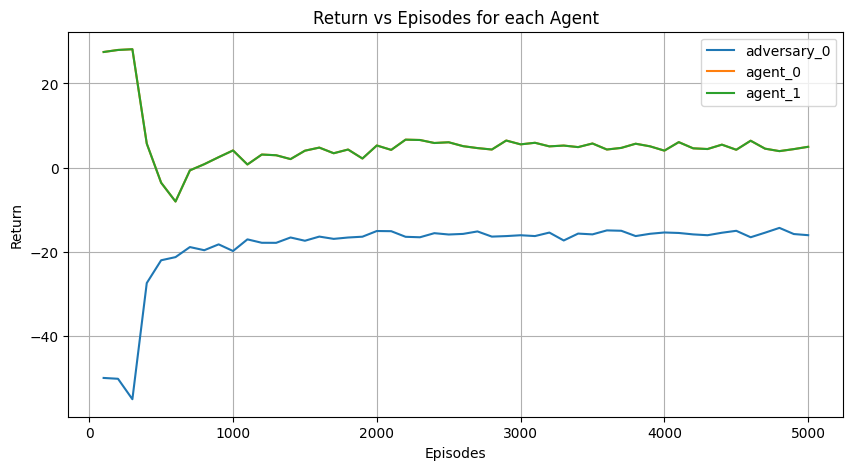

In [14]:
num_agents = return_array.shape[1]
df = pd.DataFrame(return_array, columns=[f'agent_{i - 1}' if i > 0 else 'adversary_0' for i in range(num_agents)])
df.to_excel('return_data.xlsx', index=False)

plt.figure(figsize=(10, 5))
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Return vs Episodes for each Agent')
plt.grid(True)

for agent in range(num_agents):
    agent_returns = return_array[:, agent]
    if agent == 0:
        plt.plot(range(100, len(agent_returns) * 100 + 100, 100), return_array[:, 0], label=f'adversary_0')
    else:
        plt.plot(range(100, len(agent_returns) * 100 + 100, 100), agent_returns, label=f'agent_{agent - 1}')

plt.legend()
plt.savefig('return_plot.png')
plt.show()